# Tobacco 800 page stream segmentation experiments
> Image CNN

* img_training.ipynb
* train_text_cnn.ipynb
* text_activations.ipynb
* img_activations.ipynb
* sequence_clf_from_embs.ipynb
    * alterar a label

**Imports**

In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report

**Seed**

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

# tensorflow RNG
# tf.random.set_seed(seed)

## Load Data

In [5]:
path = Path("/mnt/nas/databases/Tobacco800/unziped/page_imgs/raw")

In [6]:
images = get_image_files(path)

In [7]:
df = pd.read_csv('/mnt/nas/databases/Tobacco800/unziped/train.csv', delimiter=';',  usecols=['binder','docid','class', 'text'])

In [8]:
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(1031, 4)
(1019, 4)


In [9]:
df['split'] = 'train';print(df.shape); df.head()

(1019, 5)


,binder,docid,class,text,split
0,Tobacco800,aah97e00-page02_1,FirstPage,"Dr. M.A. Manzelli, PHILIP MORRIS INC., Research Center, P.O. Box 3 D Richmond, Va. 23206 U.S.A. Dear Art, Please find enclosed a proposed program for your visit in Europe. As you will see, this program contains two major points: a) A two-days meeting in Neuchätel with all people in Europe involved in infestation control (proposed program included). b) Visit of all PM Europe production centers with the purpose of: - training people in Charge of the insect indenti-fication - inspection of the sanitary conditions One of our main problems is the insect Identification and ...",train
1,Tobacco800,aah97e00-page02_2,NextPage,"- 2 - Please let me krow if you have any changes for the proposed program. Looking forward to seeing you again, cc: Messrs. B. Kuhn E. Stoop Encl.: mentioned 1000035625",train
2,Tobacco800,aam09c00,FirstPage,"I NOIJ-04-97 13 = 25 FROM = I D : PAGE 10/17 Wachtell, Lipton, Rosen & Katz MARTIN L1PTON HERBERT M. WaCHYCLL THEODORE GEWSRTZ »ERNA*» W, NUSSBAUM RICHARD O- HATCHER DOUGLAS Sr LieBKAfSKV STEVEN M. SAR NA CMARt.CS T. MEPCRR'GK CHAIN J. FOPTCANG pBTRR C. 1AMCLLDS MICHAEL w. SCHWÄRT* Al.LAR A- MARTIN BARRV A. BRrCR IAWREHCE □. PEDQrWITZ ROBERT 0. MAZUR PAUL VIZGARRÖMSCK JR. PCTCR G- HCIM hAROlD s. «OViKOFF DAVID M. EINHORN KENNET« B. FQRREST METER C. KOPLOW THEODORE M- MIRVIS EDWARD D. MERL1HT RICHARD D. FEINTUCH DANIEL A. NEPP ERIC M. ROTR WAHREN R. STERN ANDREW R. BROWN ST EIN MICHAEL H...",train
3,Tobacco800,aao54e00_1,FirstPage,"i PHILIP .MORRIS INCORPORATED 120 PARK AVENUE, N EW YORK. N. Y. 10017 John T.-Landhy SENIOR VICC PRESIDENT _ , r . n n - . oirector of Marketing February 15, 19 83 Dear Ms. Ober: Your letter of February 3 was received by this Office yesterday. We attempted to reach you by telephone iinmediately but were unable to find a listed number in New Haven. I had hoped to arrange an appointment for one of our executives to discuss with you and your concerned ...",train
4,Tobacco800,aao54e00_2,NextPage,"In the meantime, I hope you and your friends are continuing to enjoy your Marlboro Lights ciga-rettes. We don't think you can find a better"" cigarette on the market. ■Thank you. Ms. Angela Ober 221 Farnham Avenue New Haven, Connecticut 06515",train


In [10]:
df['split'][-200:] = 'valid'; df.iloc[-202:-198];

In [11]:
df[df['split']=='train']

,binder,docid,class,text,split
0,Tobacco800,aah97e00-page02_1,FirstPage,"Dr. M.A. Manzelli, PHILIP MORRIS INC., Research Center, P.O. Box 3 D Richmond, Va. 23206 U.S.A. Dear Art, Please find enclosed a proposed program for your visit in Europe. As you will see, this program contains two major points: a) A two-days meeting in Neuchätel with all people in Europe involved in infestation control (proposed program included). b) Visit of all PM Europe production centers with the purpose of: - training people in Charge of the insect indenti-fication - inspection of the sanitary conditions One of our main problems is the insect Identification and ...",train
1,Tobacco800,aah97e00-page02_2,NextPage,"- 2 - Please let me krow if you have any changes for the proposed program. Looking forward to seeing you again, cc: Messrs. B. Kuhn E. Stoop Encl.: mentioned 1000035625",train
2,Tobacco800,aam09c00,FirstPage,"I NOIJ-04-97 13 = 25 FROM = I D : PAGE 10/17 Wachtell, Lipton, Rosen & Katz MARTIN L1PTON HERBERT M. WaCHYCLL THEODORE GEWSRTZ »ERNA*» W, NUSSBAUM RICHARD O- HATCHER DOUGLAS Sr LieBKAfSKV STEVEN M. SAR NA CMARt.CS T. MEPCRR'GK CHAIN J. FOPTCANG pBTRR C. 1AMCLLDS MICHAEL w. SCHWÄRT* Al.LAR A- MARTIN BARRV A. BRrCR IAWREHCE □. PEDQrWITZ ROBERT 0. MAZUR PAUL VIZGARRÖMSCK JR. PCTCR G- HCIM hAROlD s. «OViKOFF DAVID M. EINHORN KENNET« B. FQRREST METER C. KOPLOW THEODORE M- MIRVIS EDWARD D. MERL1HT RICHARD D. FEINTUCH DANIEL A. NEPP ERIC M. ROTR WAHREN R. STERN ANDREW R. BROWN ST EIN MICHAEL H...",train
3,Tobacco800,aao54e00_1,FirstPage,"i PHILIP .MORRIS INCORPORATED 120 PARK AVENUE, N EW YORK. N. Y. 10017 John T.-Landhy SENIOR VICC PRESIDENT _ , r . n n - . oirector of Marketing February 15, 19 83 Dear Ms. Ober: Your letter of February 3 was received by this Office yesterday. We attempted to reach you by telephone iinmediately but were unable to find a listed number in New Haven. I had hoped to arrange an appointment for one of our executives to discuss with you and your concerned ...",train
4,Tobacco800,aao54e00_2,NextPage,"In the meantime, I hope you and your friends are continuing to enjoy your Marlboro Lights ciga-rettes. We don't think you can find a better"" cigarette on the market. ■Thank you. Ms. Angela Ober 221 Farnham Avenue New Haven, Connecticut 06515",train
...,...,...,...,...,...
825,Tobacco800,pgo51e00-page04_2,NextPage,"Mr. Ray Cave May 3, 1982 Page 2 Tobacco Institute on the subject of smoking and cancer. The TI report was fully documented and based on the same body of scientific literature which we hope was reviewed by the authors of the government’s report. The TI report, however, was dismissed as ""predictable” in two sentences near the end of a four-column article Permit me to offer some point-by-point comments: • The article reported TIME’s own conclusion that nToday smoking is considered a major cause of not only lung cancer but of cancer of the larynx, oral cavity and esophagus, and a con...",train
826,Tobacco800,pgo51e00-page04_3,NextPage,"Mr. Ray Cave May 3, 1982 Page 3 • ""An epidemic (of lung cancer) araong men has existed for years, now it is being repeated among women,"" the Surgeon General claimed. The ""reason"", according to TIME: ""lung cancer may take decades to develop, and women began taking up smoking in large numbers only after World War II."" That sounds simple, but this reasoning ignores the fact that the type of lung cancer most prevalent among women (and nonsmokers) is adenocarcinoma — a cell type very weakly associated with smoking. This phenomenon was confirmed in a recent study at the Mayo Clinic...",train
827,Tobacco800,pik10a00,FirstPage,"Scripps Clinic SM 021OU5O AND Research Foundation 476 PROSPECT STREET LA JOLLA.CALIFORNIA 92037 1714] 466-2300 Januory 14, 1974 Defartment OF Experimental Pathologt ...",train
828,Tobacco800,pji44a00,FirstPage,"AUS 2 9 1994 Shook. Hardy& Bacon August 26, 1994 FEDERAL EXPRESS TO: ETS/IAQ Current Developments Report Distribution Enclosed you will find a copy of t

In [12]:
df_test = pd.read_csv('/mnt/nas/databases/Tobacco800/unziped/test.csv', delimiter=';',  usecols=['binder','docid','class'])

In [13]:
df_test['split'] = 'test'

In [14]:
df = pd.concat([df, df_test], axis=0); df.reset_index(drop=True, inplace=True); df

<ipython-input-14-e93a5f5c905d>:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df, df_test], axis=0); df.reset_index(drop=True, inplace=True); df


,binder,class,docid,split,text
0,Tobacco800,FirstPage,aah97e00-page02_1,train,"Dr. M.A. Manzelli, PHILIP MORRIS INC., Research Center, P.O. Box 3 D Richmond, Va. 23206 U.S.A. Dear Art, Please find enclosed a proposed program for your visit in Europe. As you will see, this program contains two major points: a) A two-days meeting in Neuchätel with all people in Europe involved in infestation control (proposed program included). b) Visit of all PM Europe production centers with the purpose of: - training people in Charge of the insect indenti-fication - inspection of the sanitary conditions One of our main problems is the insect Identification and ..."
1,Tobacco800,NextPage,aah97e00-page02_2,train,"- 2 - Please let me krow if you have any changes for the proposed program. Looking forward to seeing you again, cc: Messrs. B. Kuhn E. Stoop Encl.: mentioned 1000035625"
2,Tobacco800,FirstPage,aam09c00,train,"I NOIJ-04-97 13 = 25 FROM = I D : PAGE 10/17 Wachtell, Lipton, Rosen & Katz MARTIN L1PTON HERBERT M. WaCHYCLL THEODORE GEWSRTZ »ERNA*» W, NUSSBAUM RICHARD O- HATCHER DOUGLAS Sr LieBKAfSKV STEVEN M. SAR NA CMARt.CS T. MEPCRR'GK CHAIN J. FOPTCANG pBTRR C. 1AMCLLDS MICHAEL w. SCHWÄRT* Al.LAR A- MARTIN BARRV A. BRrCR IAWREHCE □. PEDQrWITZ ROBERT 0. MAZUR PAUL VIZGARRÖMSCK JR. PCTCR G- HCIM hAROlD s. «OViKOFF DAVID M. EINHORN KENNET« B. FQRREST METER C. KOPLOW THEODORE M- MIRVIS EDWARD D. MERL1HT RICHARD D. FEINTUCH DANIEL A. NEPP ERIC M. ROTR WAHREN R. STERN ANDREW R. BROWN ST EIN MICHAEL H..."
3,Tobacco800,FirstPage,aao54e00_1,train,"i PHILIP .MORRIS INCORPORATED 120 PARK AVENUE, N EW YORK. N. Y. 10017 John T.-Landhy SENIOR VICC PRESIDENT _ , r . n n - . oirector of Marketing February 15, 19 83 Dear Ms. Ober: Your letter of February 3 was received by this Office yesterday. We attempted to reach you by telephone iinmediately but were unable to find a listed number in New Haven. I had hoped to arrange an appointment for one of our executives to discuss with you and your concerned ..."
4,Tobacco800,NextPage,aao54e00_2,train,"In the meantime, I hope you and your friends are continuing to enjoy your Marlboro Lights ciga-rettes. We don't think you can find a better"" cigarette on the market. ■Thank you. Ms. Angela Ober 221 Farnham Avenue New Haven, Connecticut 06515"
...,...,...,...,...,...
1273,Tobacco800,NextPage,zrz94a00-page02_2,test,NaN
1274,Tobacco800,FirstPage,zss86d00,test,NaN
1275,Tobacco800,FirstPage,ztz52d00-page02_1,test,NaN
1276,Tobacco800,NextPage,ztz52d00-page02_2,test,NaN


In [15]:
def splitter(df):
    train = df[df['split']=='train'].index.tolist()
    valid = df[df['split']=='valid'].index.tolist()
    test = df[df['split']=='test'].index.tolist()
    return train, valid, test

In [16]:
def get_x(r): return path/f'{r["docid"]}.tif'
def get_y(r): return r['class']

In [17]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=splitter,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=224, min_scale=0.9,
                                               do_flip=False, max_rotate=0,
                                               max_warp=0),
                               Normalize.from_stats(*imagenet_stats)])

In [18]:
#dblock.summary(df)

In [19]:
dls = dblock.dataloaders(df)

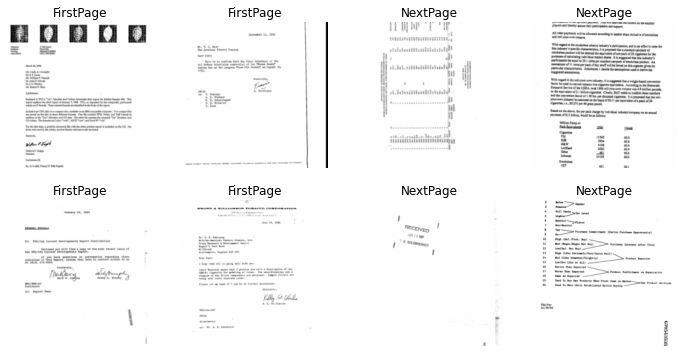

In [20]:
dls.show_batch(nrows=2, ncols=4)

In [21]:
#dls_test = dblock_test.dataloaders(df_test)

In [22]:
#dls_test.show_batch(nrows=2, ncols=4)

## Train 

In [23]:
fscore = F1Score(average='weighted')

In [24]:
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, fscore], path='./')

In [25]:
learn.freeze()

In [26]:
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

SuggestedLRs(valley=0.0008317637839354575)

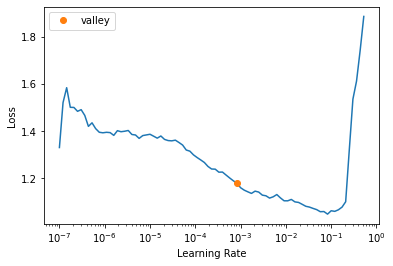

In [27]:
learn.lr_find()

In [28]:
learn.fit_one_cycle(1, 4e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.218544,1.542748,0.660000,0.651721,00:27


In [29]:
learn.unfreeze()
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      True      
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

SuggestedLRs(valley=0.0014454397605732083)

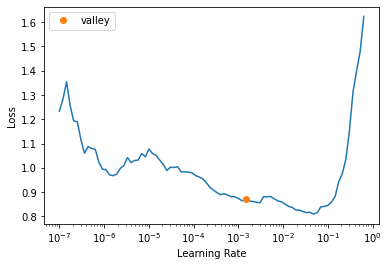

In [30]:
learn.lr_find()

In [32]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_image_no_weights_224'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.087394,4.986774,0.460000,0.298508,00:26
1,0.899696,0.865215,0.720000,0.719746,00:26
2,0.731735,0.920453,0.740000,0.736651,00:26
3,0.617549,0.762246,0.770000,0.768894,00:25


Better model found at epoch 0 with f1_score value: 0.29850783699059563.
Better model found at epoch 0 with f1_score value: 0.29850783699059563.


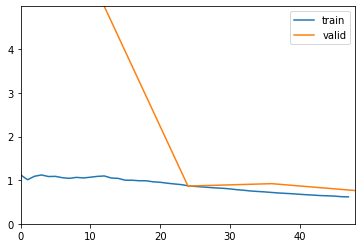

Better model found at epoch 1 with f1_score value: 0.7197459421312632.
Better model found at epoch 1 with f1_score value: 0.7197459421312632.
Better model found at epoch 2 with f1_score value: 0.7366505636070855.
Better model found at epoch 2 with f1_score value: 0.7366505636070855.
Better model found at epoch 3 with f1_score value: 0.7688942307692308.
Better model found at epoch 3 with f1_score value: 0.7688942307692308.


In [33]:
learn.fit_one_cycle(4, lr_max=slice(2e-4,2e-3))

In [34]:
learn.load("best_image_no_weights_224")

/mnt/home/fabraz/code/fastai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [35]:
dls.loaders[2]

## Valid Set Performance

In [36]:
preds, targets = learn.get_preds()
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

              precision    recall  f1-score   support

   FirstPage     0.6983    0.8804    0.7788        92
    NextPage     0.8690    0.6759    0.7604       108

    accuracy                         0.7700       200
   macro avg     0.7837    0.7782    0.7696       200
weighted avg     0.7905    0.7700    0.7689       200



In [37]:
n_samples = len(dls.train_ds); n_samples

819

## Test Set Performance

In [38]:
preds, targets = learn.get_preds(ds_idx=2)
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

              precision    recall  f1-score   support

   FirstPage     0.7845    0.9467    0.8580       150
    NextPage     0.8974    0.6422    0.7487       109

    accuracy                         0.8185       259
   macro avg     0.8410    0.7944    0.8033       259
weighted avg     0.8320    0.8185    0.8120       259

